## Уровень IQ ребенка
В исследовании был проведен анализ данных, полученных в рамках трех различных и не связанных между собой научных исследованиях.   
Цель исследования: выявить статистически значимые параметры, которые влияют на уровень IQ детей


### Описание данных   

**df_child_iq:**  
- *ppvt* - тестовый балл ребенка в возрасте 3 лет 
- *educ_cat* - образование матери (1 = нет образования, 2 = имет среднее образование, 3 = колледж, 4 = имеет высшее образование)
- *momage* - возраст становления матерью

**df_gifted:**  
- *score* - оценка IQ ребенка
- *fatheriq* - IQ отца
- *motheriq* - IQ матери
- *speak* - возраст в месяцах, когда ребенок впервые сказал "мама" или "папа"
- *count* - возраст в месяцах, когда ребенок впервые успешно досчитал до 10
- *read* - среднее количество часов в неделю, которые мать или отец читают ребенку вслух
- *edutv* - среднее количество часов в неделю, которое ребенок проводил за просмотром образовательной программы по телевизору в течение последних трех месяцев
- *cartoons* - среднее количество часов в неделю, которые ребенок проводил за просмотром мультфильмов по телевизору в течение последних трех месяцев  

**df_kid_iq** 
- *kid_score* - оценка IQ ребенка
- *mom_hs* (0 - мама ходила, 1 - не ходила в старшую школу)
- *mom_iq* - IQ матери (0 = no HS, 1 = at least HS grad)
- *mom_work* - 
- *mom_age* - возраст становления матерью

Данные датасеты не связаны между собой, а представляют результаты независимых исследований 

In [57]:
import pandas as pd 
import numpy as np

import pingouin as pg
import statsmodels.api as sm
import scipy.stats as ss
import statsmodels.formula.api as smf 
from statsmodels.stats.multicomp import (MultiComparison)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import seaborn as sns 
import matplotlib.pyplot as plt 

%matplotlib inline 

In [2]:
# Считать датасеты
path = './data/'
df_child_iq = pd.read_csv(path + 'child_iq.csv')
df_gifted = pd.read_csv(path + 'gifted.csv')
df_kid_iq = pd.read_csv(path + 'kid_iq.csv')

### df_child_iq

Начнем анализ с датасета, в котором представлены данные о матери (возраст, в котором был рожден ребенок, образование) и уровень IQ ребенка  

#### Проведем предварительное исследование данных

In [3]:
df_child_iq.head()

,Unnamed: 0,ppvt,educ_cat,momage
0,1,120,2,21
1,2,89,1,17
2,3,78,2,19
3,4,42,1,20
4,5,115,4,26


In [4]:
new_columns_child_iq = {'Unnamed: 0': 'number', 
                        'educ_cat': 'mom_educ', 
                        'momage': 'mom_age'}
df_child_iq = df_child_iq\
    .rename(columns=new_columns_child_iq)

В датасете не обнаружено пропущенных значений, всего в датасете имеется 400 записей

In [5]:
df_child_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   number    400 non-null    int64
 1   ppvt      400 non-null    int64
 2   mom_educ  400 non-null    int64
 3   mom_age   400 non-null    int64
dtypes: int64(4)
memory usage: 12.6 KB


In [6]:
if df_child_iq.duplicated().sum() > 0:
    print("В данных есть дубликаты.")
    # Удалить дубликаты
    df_child_iq = df_child_iq.drop_duplicates()
    print("В данных больше нет дубликатов")
else:
    print('В данных нет дубликатов.')

В данных нет дубликатов.


In [7]:
df_child_iq.describe()

,number,ppvt,mom_educ,mom_age
count,400.000000,400.000000,400.000000,400.000000
mean,200.500000,86.932500,2.112500,22.790000
std,115.614301,20.440094,0.813325,2.689607
min,1.000000,20.000000,1.000000,17.000000
25%,100.750000,74.000000,2.000000,21.000000
50%,200.500000,90.000000,2.000000,23.000000
75%,300.250000,102.000000,3.000000,25.000000
max,400.000000,144.000000,4.000000,29.000000


In [8]:
df_child_iq.groupby('mom_educ').agg({'ppvt': ['count', 'mean', 'std', 'min', 'max', 'var']})

ppvt                                           
         count       mean        std min  max         var
mom_educ                                                 
1           85  78.447059  22.715899  20  136  516.012045
2          212  88.702830  19.055703  38  126  363.119802
3           76  87.789474  18.388631  42  122  338.141754
4           27  97.333333  21.136916  52  144  446.769231

Группа, в которой mom_educ == 4 самая малочисленная, необходимо проверить данные на нормальность распределения 

In [9]:
# Проводим тест Шапиро-Уилка
stat, p_value = ss.shapiro(df_child_iq.query("mom_educ == 4").ppvt)

# Выводим результаты теста
print("Статистика теста:", stat)
print("p-value:", p_value)

# Оцениваем результаты теста
alpha = 0.05
if p_value > alpha:
    print("Данные похожи на нормальное распределение")
else:
    print("Данные не похожи на нормальное распределение")

Статистика теста: 0.9380358457565308
p-value: 0.10898029059171677
Данные похожи на нормальное распределение


### Построим графики 

Text(37.597222222222214, 0.5, 'IQ ребенка')

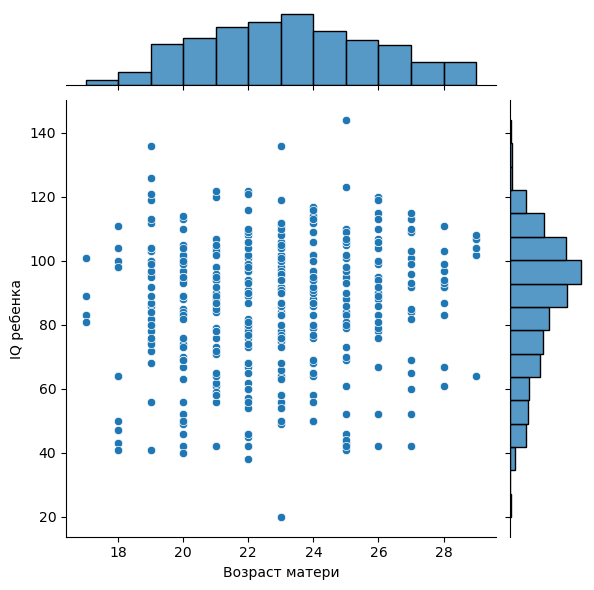

In [10]:
tips = sns.load_dataset("tips")
g = sns.jointplot(x='mom_age', y='ppvt', data=df_child_iq)
plt.xlabel('Возраст матери')
plt.ylabel('IQ ребенка')

Text(0, 0.5, 'IQ ребенка')

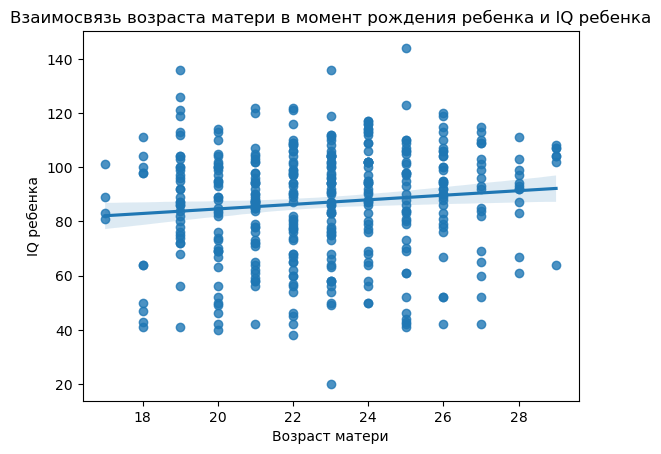

In [11]:
sns.regplot(x='mom_age', y='ppvt', data=df_child_iq)
plt.title('Взаимосвязь возраста матери в момент рождения ребенка и IQ ребенка')
plt.xlabel('Возраст матери')
plt.ylabel('IQ ребенка')

Text(0, 0.5, 'IQ ребенка')

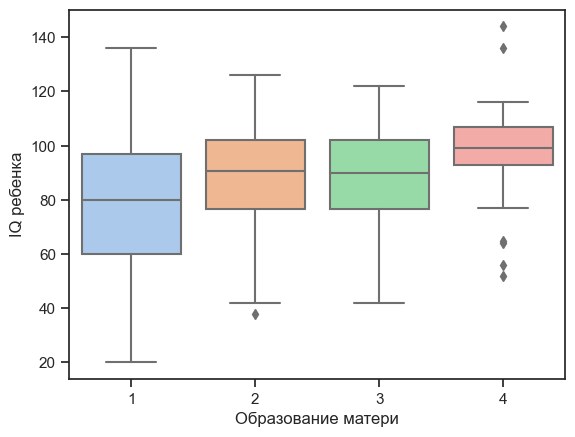

In [12]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="mom_educ", y="ppvt",
            data=df_child_iq)
plt.xlabel('Образование матери')
plt.ylabel('IQ ребенка')

### Вывод:  
После проведения предварительного исследования даных, можно выдвинуть несколько предположений.
1. Уровень IQ ребенка зависит от возраста матери (для проведения данного исследования проведем дисперсионный анализ, чтобы узнать есть ли отличия между средними в группах, также провдем регрессионный анализ)
2. Уровень IQ ребенка зависит от образования, котрое получила мать (Проведем дисперсионный анализ, чтобы выявить различим между группами, затем проведем т-тест, чтобы выявить пары в которых статистически значимо различаются средние значения.)

### Гипотезы:  
$H_0$ – коэффициент корреляции равен нулю  
$H_1$ – коэффициент корреляции не равен нулю

In [13]:
df_dummy = df_child_iq

In [14]:
def convert_dict(df_dummy, mom_educ_dict):
    for i in mom_educ_dict.keys():
        df_dummy[mom_educ_dict[i]] = df_dummy.mom_educ == i
        df_dummy[mom_educ_dict[i]] = df_dummy[mom_educ_dict[i]].astype('int')

In [15]:
mom_educ_dict = {1: 'mom_educ_1', 2: 'mom_educ_2', 3: 'mom_educ_3', 4: 'mom_educ_4'}
convert_dict(df_dummy, mom_educ_dict)

In [16]:
mom_educ_dict[1]

'mom_educ_1'

In [17]:
df_dummy = df_dummy.drop(columns=['mom_educ','number', 'mom_educ_4'], axis=1)

In [18]:
# Y = одномерный массив с ЗП, X - массив со всеми нужными нам НП
X = df_dummy.drop(['ppvt'], axis=1)
y = df_dummy.ppvt

X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
model = sm.OLS(y, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                   ppvt   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     6.280
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           6.59e-05
Time:                        11:57:55   Log-Likelihood:                -1761.7
No. Observations:                 400   AIC:                             3533.
Df Residuals:                     395   BIC:                             3553.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.9169     10.964      8.201      0.0

### Вывод:
IQ ребенка статистически значимо не зависит от возраста матери в момент его рождения  
Коэффициент корреляции между уровнем IQ ребенка и возрастом матери равен 0

### Гипотезы:  
$H_0$ - ни одно из выборочных средних значений уровня IQ ребенка не отличается от другого в группах с различным уровнем образования матери (нет различий) 
$H_1$ - хотя бы одно выборочное среднее отличается от других (есть различия как минимум между двумя группами)  
$\alpha = 0,05$

In [19]:
pg.welch_anova(data=df_child_iq, dv="ppvt", between="mom_educ")

,Source,ddof1,ddof2,F,p-unc,np2
0,mom_educ,3,96.950853,6.639036,0.000399,0.058555


Отвергаем нулевую гипотезу, то есть хотя бы одно выборочное среднее значение уровня IQ ребенка в какой-то группе статистически значимо различается с другой 

### Гипотезы:  
$H_0$ - ни одно из выборочных средних значний уровня IQ ребенка не отличается от другого (нет различий) (разбивка по возрасту матери в момент рождения ребенка)  
$H_1$ - хотя бы одно выборочное среднее отличается от других (есть различия как минимум между двумя группами)  
$\alpha = 0,05$

In [20]:
pg.welch_anova(data=df_child_iq, dv="ppvt", between="mom_age")

,Source,ddof1,ddof2,F,p-unc,np2
0,mom_age,12,65.80216,1.365207,0.205293,0.043299


Принимаем нулевую гипотезу, ни одно из выборочных средних не отличается от другого (нет различий) 

Проведем Т-тест с использованием критерия Тьюки, который иначе рассчитывает стандартную ошибку – в результате критерий Тьюки более консервативен, чем обычный t-критерий

In [21]:
MultiComp = MultiComparison(df_child_iq.ppvt, df_child_iq.mom_educ)

print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  10.2558 0.0004   3.662 16.8496   True
     1      3   9.3424 0.0165  1.2341 17.4507   True
     1      4  18.8863 0.0001    7.54 30.2325   True
     2      3  -0.9134 0.9861 -7.7802  5.9535  False
     2      4   8.6305  0.148 -1.8645 19.1255  False
     3      4   9.5439 0.1424 -1.9632 21.0509  False
----------------------------------------------------


В результате проведенного Т-теста получаем, что IQ детей у матерей, которые не получили образование статистически значимо различаются со всеми остальными группами. IQ детей из группы mom_educ == 1 ниже, чем в других группах.

### Выводы:
1. Уровень IQ детей у матерей, которые не получили образование, статистически значимо отличается от других групп (имеют меньший IQ)
2. Значение IQ детей не зависит от возраста, в котором мать родила ребенка 

## df_gifted 
В датасете приведены данные одаренных детей. Представленные данные никак не могут быть репрезентативной выборкой генеральной совокупности

In [22]:
df_gifted.head()

,score,fatheriq,motheriq,speak,count,read,edutv,cartoons
0,159,115,117,18,26,1.9,3.00,2.00
1,164,117,113,20,37,2.5,1.75,3.25
2,154,115,118,20,32,2.2,2.75,2.50
3,157,113,131,12,24,1.7,2.75,2.25
4,156,110,109,17,34,2.2,2.25,2.50


In [23]:
df_gifted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   score     36 non-null     int64  
 1   fatheriq  36 non-null     int64  
 2   motheriq  36 non-null     int64  
 3   speak     36 non-null     int64  
 4   count     36 non-null     int64  
 5   read      36 non-null     float64
 6   edutv     36 non-null     float64
 7   cartoons  36 non-null     float64
dtypes: float64(3), int64(5)
memory usage: 2.4 KB


In [24]:
df_gifted.describe()

,score,fatheriq,motheriq,speak,count,read,edutv,cartoons
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,159.138889,114.777778,118.166667,18.000000,30.694444,2.136111,1.958333,3.062500
std,4.630043,3.481470,6.504943,3.224903,4.314887,0.205847,0.559017,0.627851
min,150.000000,110.000000,101.000000,10.000000,21.000000,1.700000,0.750000,1.750000
25%,155.000000,112.000000,113.750000,17.000000,28.000000,2.000000,1.750000,2.687500
50%,159.000000,115.000000,118.000000,18.000000,31.000000,2.200000,2.000000,3.000000
75%,162.000000,116.250000,122.250000,20.000000,34.250000,2.300000,2.250000,3.500000
max,169.000000,126.000000,131.000000,23.000000,39.000000,2.500000,3.000000,4.500000


In [25]:
pg.normality(df_gifted)

,W,pval,normal
score,0.980511,0.762456,True
fatheriq,0.908325,0.005809,False
motheriq,0.980536,0.763293,True
speak,0.944493,0.070188,True
count,0.977760,0.669330,True
read,0.933985,0.033111,False
edutv,0.961635,0.241328,True
cartoons,0.977386,0.656606,True


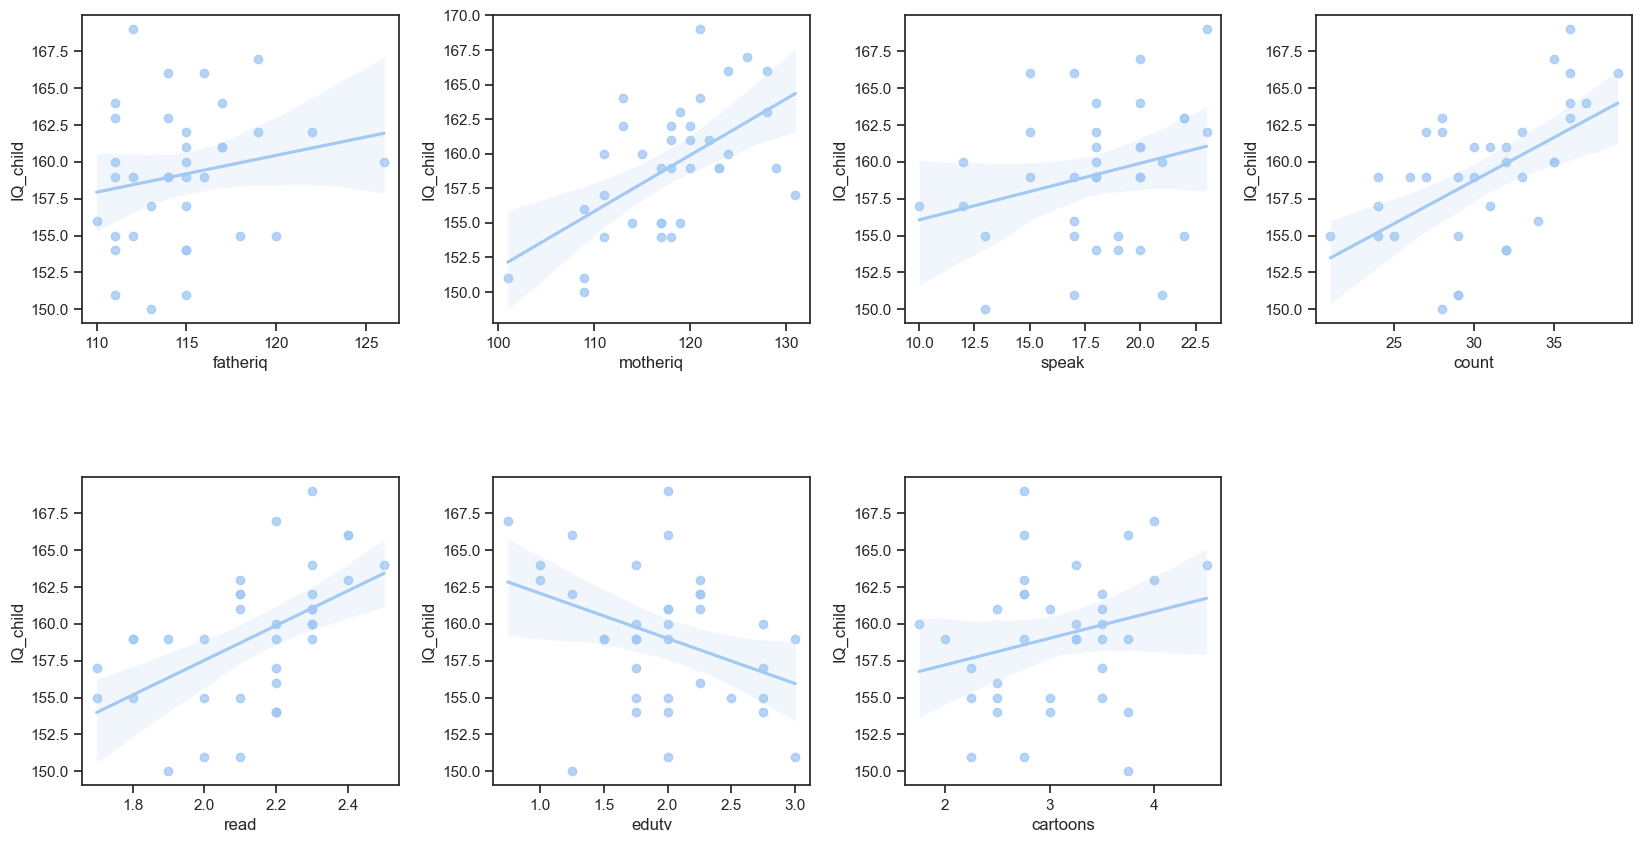

In [26]:
fig = plt.figure(figsize=(20, 10))
name_col = df_gifted.columns
for i in range(1, len(name_col)):
    plt.subplot(2, 4, i)
    sns.regplot(x=name_col[i], y='score', data=df_gifted)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.ylabel('IQ_child') 
    plt.xlabel(name_col[i])


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


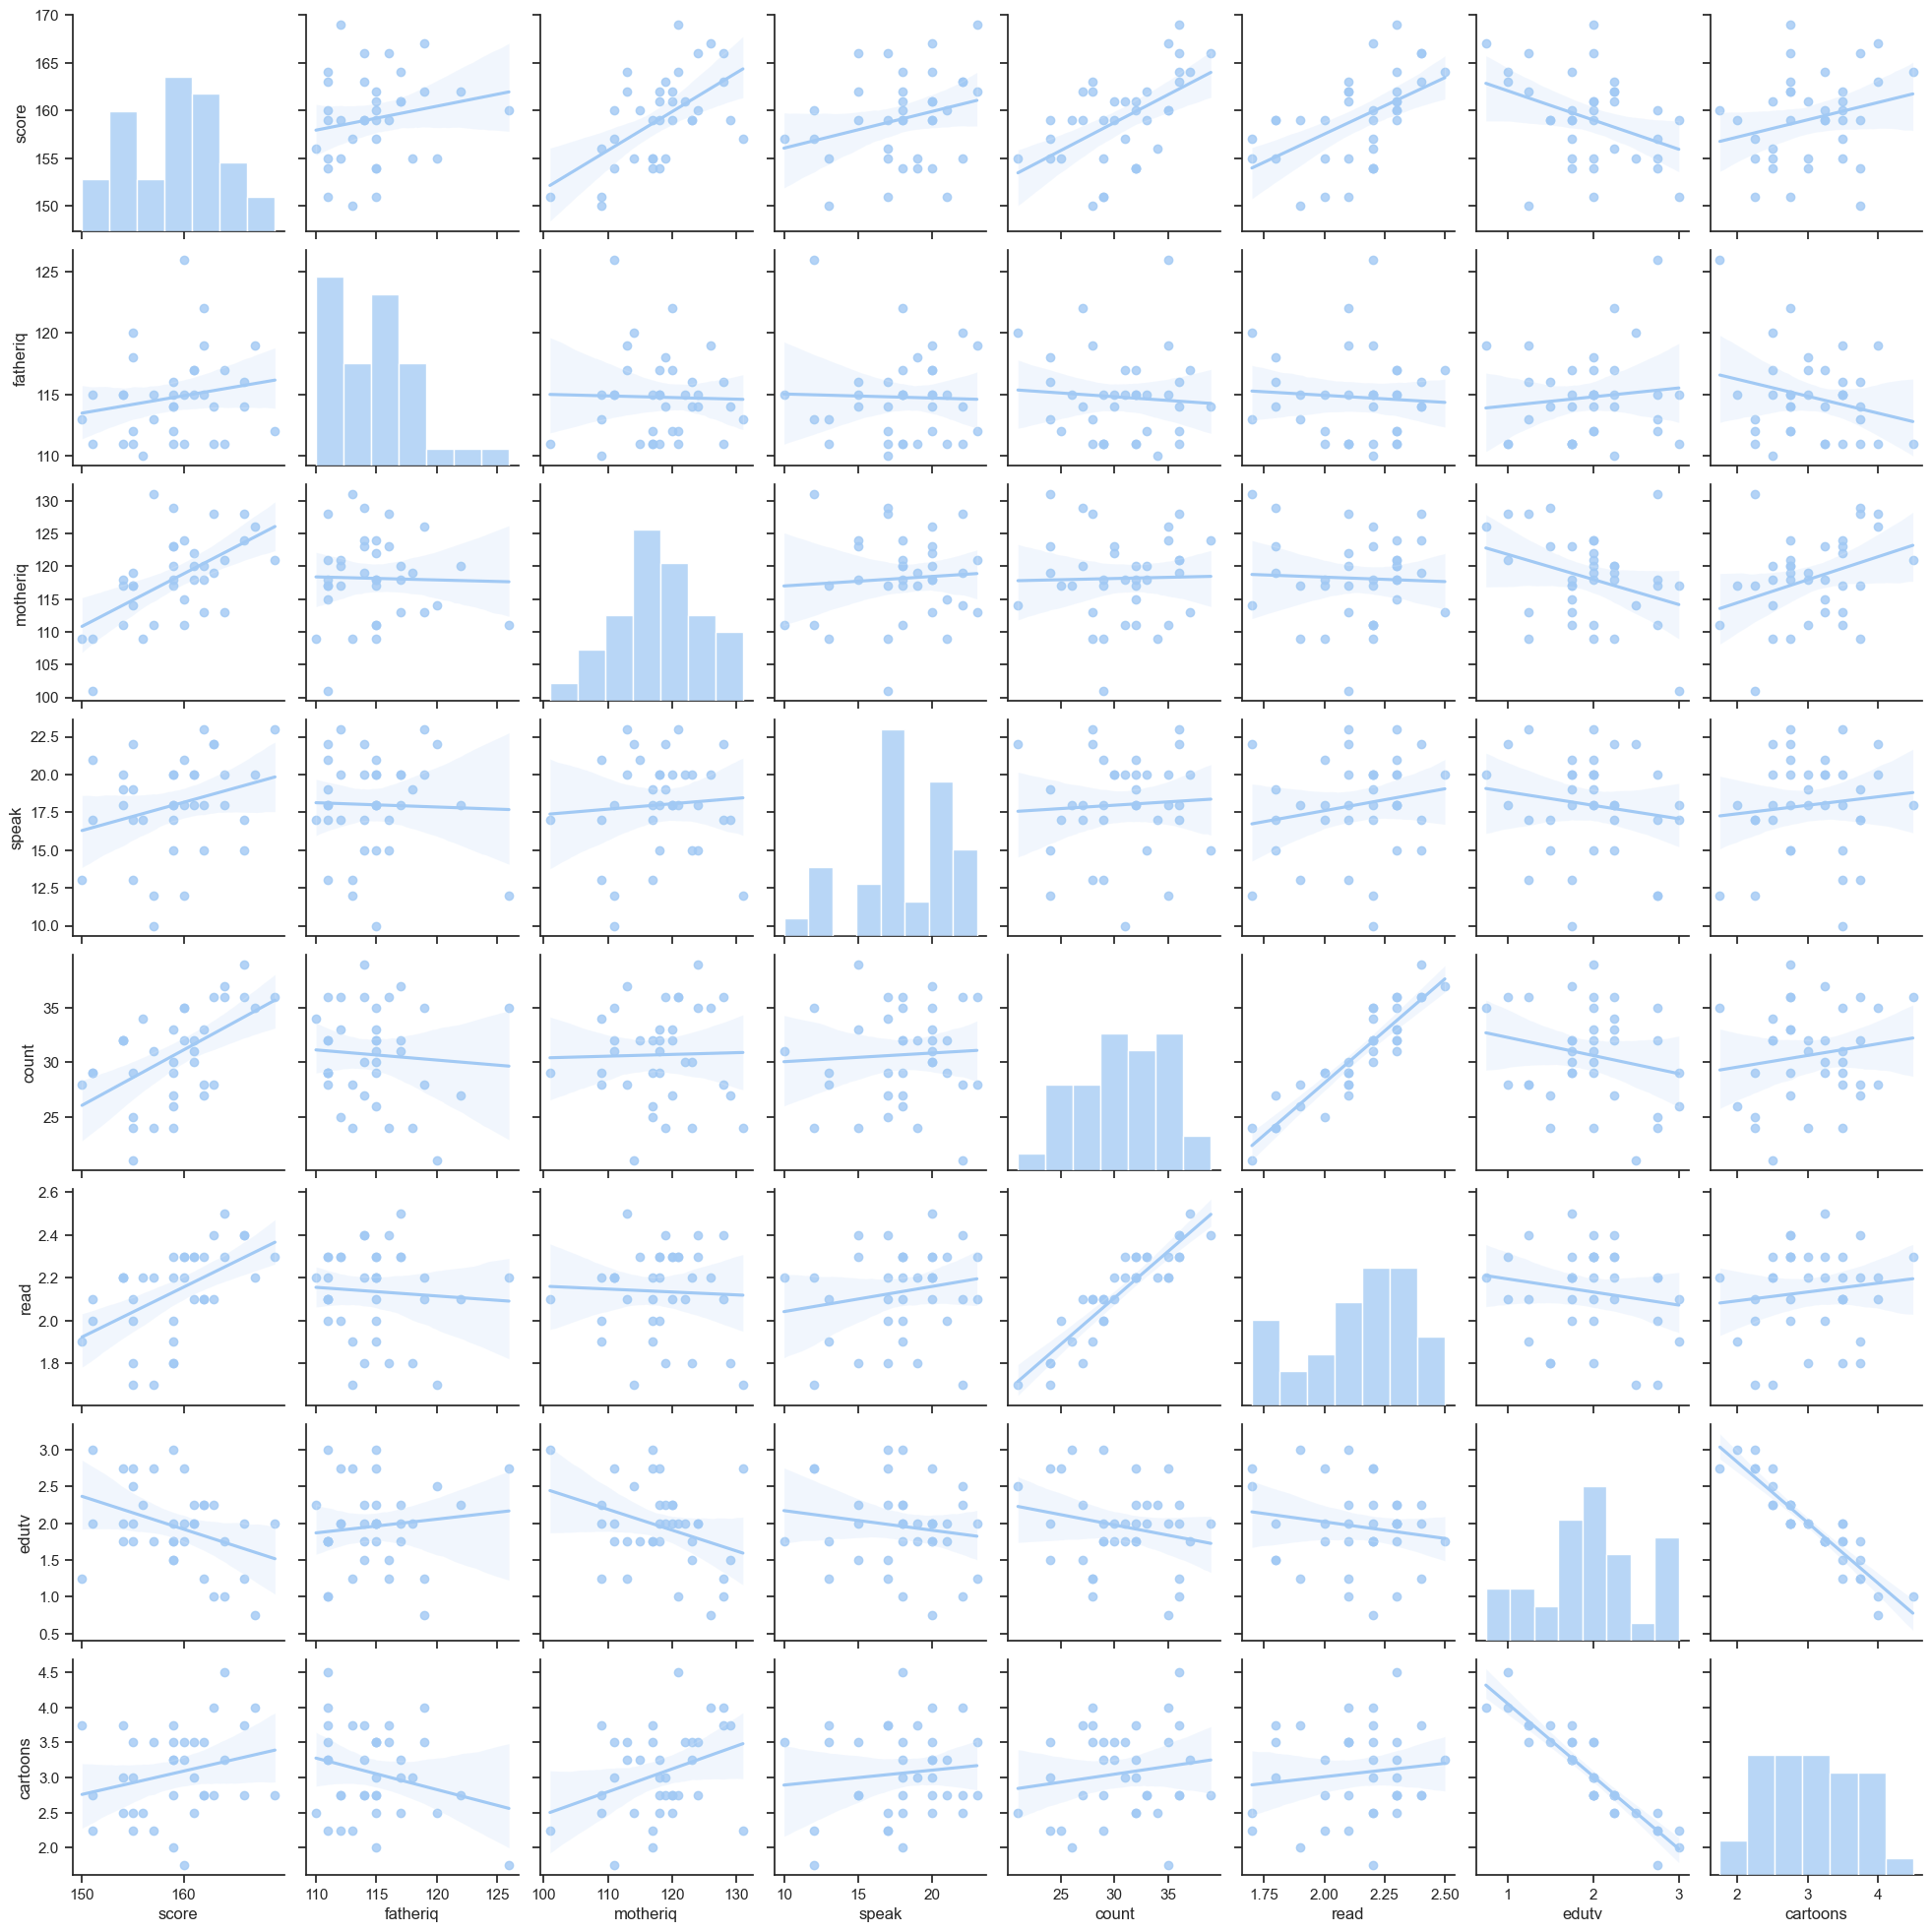

In [27]:
sns.pairplot(df_gifted, kind = 'reg')

<Axes: >

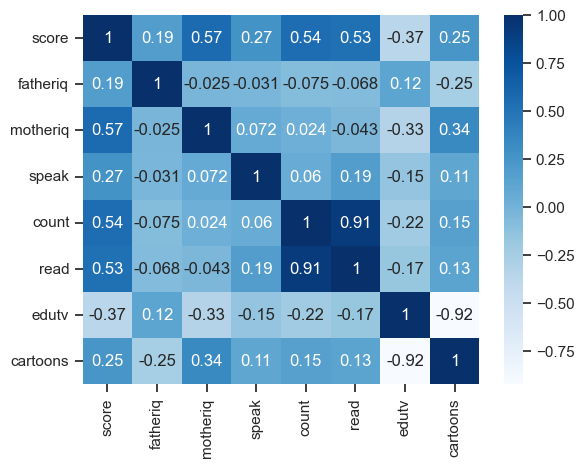

In [28]:
sns.heatmap(df_gifted.corr(method='pearson'),annot=True,cmap='Blues')

Выводы из полученных графиков:
1. Судя по графикам оценка IQ ребенка обратно пропорциональна среднему количеству часов в неделю, которое ребенок проводил за просмотром образовательных программы по телевизору, на мой взгляд это не отражает реальность. Также исходя из графиков количество часов, которое ребенок потратил на просмотр мультфильмов, прямо пропорционально уровню IQ. На мой взгляд, необходимо сложить два показателя в один, получив общее время просмотра телевизионного контента. 
2. Из графиков видно, что два показателя: возраст в месяцах, когда ребенок впервые успешно досчитал до 10 и среднее количество часов в неделю, которые мать или отец читают ребенку вслух, сильно коррелируют межд собой. Для построения качественной модели необходимо исключить один из этих параметров во избежании коллинеарности между пармети.
3. Необходимо посчитать коэффициент инфляции дисперсии или VIF — это мера, которая помогает обнаружить степень мультиколлинеарности в множественной регрессионной модели. 

In [29]:
df_gifted['tv'] = df_gifted.edutv + df_gifted.cartoons

In [30]:
df_gifted.head()

,score,fatheriq,motheriq,speak,count,read,edutv,cartoons,tv
0,159,115,117,18,26,1.9,3.00,2.00,5.00
1,164,117,113,20,37,2.5,1.75,3.25,5.00
2,154,115,118,20,32,2.2,2.75,2.50,5.25
3,157,113,131,12,24,1.7,2.75,2.25,5.00
4,156,110,109,17,34,2.2,2.25,2.50,4.75


Text(0.5, 1.0, 'Взаимосвязь уровня IQ и среднего времени просмотра телефизионного контента')

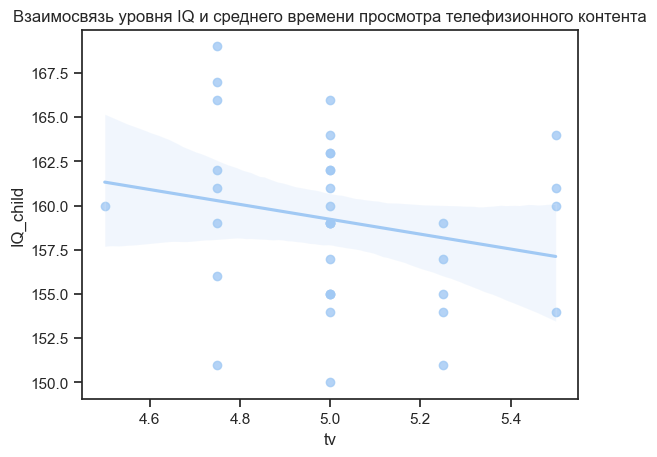

In [31]:
sns.regplot(x='tv', y='score', data=df_gifted)
plt.ylabel('IQ_child') 
plt.xlabel('tv')
plt.title('Взаимосвязь уровня IQ и среднего времени просмотра телефизионного контента')

In [32]:
features = "+".join(list(df_gifted.columns)[1:])
y, X = dmatrices('score ~' + features, df_gifted, return_type='dataframe')

In [33]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [34]:
vif.round(1)

,VIF Factor,features
0,3096.7,Intercept
1,1.2,fatheriq
2,1.2,motheriq
3,1.2,speak
4,6.9,count
5,6.9,read
6,inf,edutv
7,inf,cartoons
8,inf,tv


Исследование мультиколлинеарности с помощью Statsmodels показало, что некоторые переменные (count, read, edutv, cartoons, tv)  коррелируют друг с другом. Необходимо исключить из модели следующие поля: count, edutv, cartoons. Проверим новую модель на мультиколлинеарность.

In [35]:
features = "+".join(['fatheriq', 'motheriq', 'speak', 'read', 'tv'])
y, X = dmatrices('score ~' + features, df_gifted, return_type='dataframe')

In [36]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [37]:
vif.round(1)

,VIF Factor,features
0,2982.4,Intercept
1,1.2,fatheriq
2,1.0,motheriq
3,1.1,speak
4,1.0,read
5,1.2,tv


Вывод приведенный выше показывает, что мультиколлинеарности нет или она незначительна, коэффициенты регрессии можно считать надежными.

In [38]:
# Y = одномерный массив с ЗП, X - массив со всеми нужными нам НП
X = df_gifted.drop(['score', 'count', 'edutv', 'cartoons'], axis=1)
y = df_gifted.score

X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
model = sm.OLS(y, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     16.45
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           8.11e-08
Time:                        11:58:16   Log-Likelihood:                -81.996
No. Observations:                  36   AIC:                             176.0
Df Residuals:                      30   BIC:                             185.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.5662     23.533      2.999      0.0

In [39]:
X = df_gifted.drop(['score', 'fatheriq', 'read', 'edutv', 'cartoons'], axis=1)
y = df_gifted.score

X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
model = sm.OLS(y, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     17.70
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           1.17e-07
Time:                        11:58:16   Log-Likelihood:                -84.346
No. Observations:                  36   AIC:                             178.7
Df Residuals:                      31   BIC:                             186.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.5413     12.875      8.663      0.0

In [40]:
X = df_gifted.drop(['score', 'count', 'edutv', 'tv', 'cartoons'], axis=1)
y = df_gifted.score

X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
model = sm.OLS(y, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     18.43
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           7.60e-08
Time:                        11:58:16   Log-Likelihood:                -83.833
No. Observations:                  36   AIC:                             177.7
Df Residuals:                      31   BIC:                             185.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.7093     18.315      2.332      0.0

In [41]:
X = df_gifted.drop(['score', 'count', 'speak', 'edutv', 'cartoons'], axis=1)

X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
model = sm.OLS(y, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     19.89
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           3.34e-08
Time:                        11:58:16   Log-Likelihood:                -82.856
No. Observations:                  36   AIC:                             175.7
Df Residuals:                      31   BIC:                             183.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.6460     23.571      3.124      0.0

In [42]:
X = df_gifted.drop(['score', 'fatheriq', 'count', 'speak', 'edutv', 'cartoons'], axis=1)

X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
model = sm.OLS(y, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     24.40
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           2.09e-08
Time:                        11:58:16   Log-Likelihood:                -84.323
No. Observations:                  36   AIC:                             176.6
Df Residuals:                      32   BIC:                             183.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.8547     13.026      8.126      0.0

### Проверим распределение остатков на нормальность 

In [66]:
def calculate_remains(model, perem):
    b_1 = results.params[perem]
    b_0 = results.params['const']

    f = lambda x: x * b_1 + b_0

    remains = df_gifted.read.apply(f)
    result = np.array(df_gifted.score.values)  - np.array(remains.values)
    return result

----------------------
Axes(0.125,0.11;0.775x0.77)
          W      pval  normal
0  0.981791  0.804068    True
----------------------
Axes(0.125,0.11;0.775x0.77)
          W      pval  normal
0  0.963743  0.279658    True
----------------------
Axes(0.125,0.11;0.775x0.77)
          W      pval  normal
0  0.980276  0.754639    True


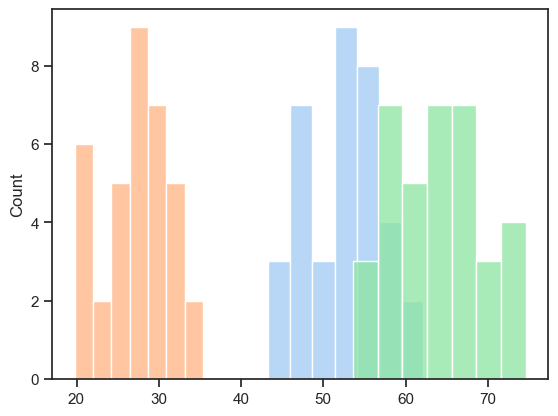

In [75]:
perem = ['motheriq', 'read', 'tv']
for item in perem:
    result = calculate_remains(model, item)
    print('----------------------')
    print(sns.histplot(result))
    print(pg.normality(result))

Остатки распределены нормально

### Выводы:
Оценка IQ детей статистически значимо зависит от следующих факторов: прямопропорционально от уровня IQ матери и среднего количество часов  в неделю, которые мать или отец читают ребенку вслух, а также обратнопропорционально зависит от количества  часов в неделю, которое ребенок проводил за просмотром телевизеонного контента. 

Питон ругается на показатель condition number, который может сигнализировать о наличии сильной мультиколлинеарности или других численных проблем. Исследование переменных, приведенное выше, показало, что мультиколлинеарности среди выбранных переменных нет, но все же не буду делать выводы о том, что данная математическая модель предсказывает уровень IQ ребенка. 

### df_kids_iq


In [43]:
df_kid_iq.head()

,Unnamed: 0,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,1,65,1,121.117529,4,27
1,2,98,1,89.361882,4,25
2,3,85,1,115.443165,4,27
3,4,83,1,99.449639,3,25
4,5,115,1,92.745710,4,27


In [44]:
df_kid_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  434 non-null    int64  
 1   kid_score   434 non-null    int64  
 2   mom_hs      434 non-null    int64  
 3   mom_iq      434 non-null    float64
 4   mom_work    434 non-null    int64  
 5   mom_age     434 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 20.5 KB


In [45]:
df_kid_iq.describe()

,Unnamed: 0,kid_score,mom_hs,mom_iq,mom_work,mom_age
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,217.500000,86.797235,0.785714,100.000000,2.896313,22.785714
std,125.429263,20.410688,0.410799,15.000000,1.181394,2.701070
min,1.000000,20.000000,0.000000,71.037405,1.000000,17.000000
25%,109.250000,74.000000,1.000000,88.660321,2.000000,21.000000
50%,217.500000,90.000000,1.000000,97.915254,3.000000,23.000000
75%,325.750000,102.000000,1.000000,110.272742,4.000000,25.000000
max,434.000000,144.000000,1.000000,138.893106,4.000000,29.000000


<Axes: xlabel='kid_score', ylabel='Count'>

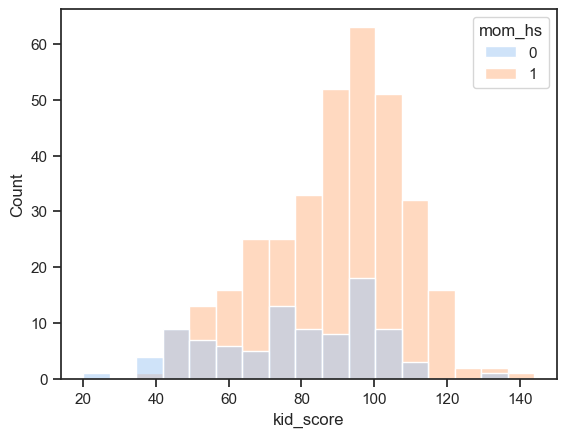

In [46]:
sns.histplot(x='kid_score', hue='mom_hs', data=df_kid_iq)